In [26]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras import optimizers

In [27]:
# Data preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

TRAIN_DATA_PATH = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised'
TEST_DATA_PATH = '/Users/kaylienguyen/Downloads/FER_dataset/testrevised'
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 64

In [28]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

Found 28614 images belonging to 7 classes.
Found 7071 images belonging to 7 classes.


In [29]:
input_shape = (48, 48, 1)
epochs = 40
conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(48, 48, 3))
conv_base.trainable = False

model = Sequential([
    Conv2D(filters=10, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape, kernel_regularizer=l2(.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(filters=20, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(7, activation='softmax')
])

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [30]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizers.Adam(lr=1e-4))
model.fit(
    train_generator,
    epochs=epochs,
    batch_size=64,
    validation_split=0.2,
    validation_data = test_generator  
)


test_loss, test_accuracy = model.evaluate_generator(test_generator)
print('Test Loss: ', test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/40
448/448 [==============================] - 50s 108ms/step - loss: 1.7163 - accuracy: 0.3173 - val_loss: 1.6766 - val_accuracy: 0.3338
Epoch 2/40
448/448 [==============================] - 50s 111ms/step - loss: 1.5329 - accuracy: 0.4108 - val_loss: 1.3970 - val_accuracy: 0.4666
Epoch 3/40
448/448 [==============================] - 51s 113ms/step - loss: 1.4264 - accuracy: 0.4528 - val_loss: 1.3518 - val_accuracy: 0.4835
Epoch 4/40
448/448 [==============================] - 43s 97ms/step - loss: 1.3681 - accuracy: 0.4813 - val_loss: 1.3400 - val_accuracy: 0.4906
Epoch 5/40
448/448 [==============================] - 45s 101ms/step - loss: 1.3223 - accuracy: 0.4999 - val_loss: 1.2648 - val_accuracy: 0.5214
Epoch 6/40
448/448 [==============================] - 45s 100ms/step - loss: 1.2889 - accuracy: 0.5140 - val_loss: 1.3081 - val_accuracy: 0.5011
Epoch 7/40
448/448 [==============================] - 47s 104ms/step - loss: 1.2602 - accuracy: 0.5276 - val_loss: 1.4052 - val_acc

/var/folders/3m/hxyrmk3x0fndxrfylccz8ldh0000gn/T/ipykernel_98249/3264359366.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator)


Test Loss:  1.403782606124878
Test Accuracy: 0.5751661658287048


111/111 [==============================] - 3s 25ms/step


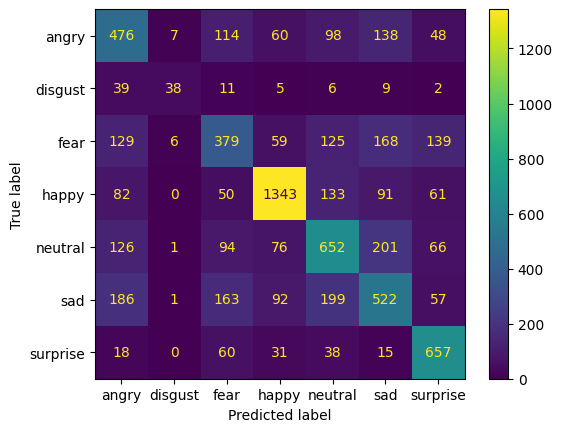

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

confusion_mtx = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = emotion_labels)
disp.plot()
plt.show()


In [38]:


import numpy as np
from PIL import Image


lst = [i for i in range(7)]
lst2 = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotion_dict = {lst[i] : lst2[i] for i in range(len(lst))}

print("Given the following image, write the corresponding number to emotion that you think it is")
print(f'Here are the corresponding numbers for emotions: {emotion_dict}')

user_score = 0
model_score = 0

for i in range(5):  

    test_batch, true_labels = next(test_generator)

    
    idx = np.random.randint(0, len(test_batch))
    #print(idx)
    image = test_batch[idx]

    true_label = np.argmax(true_labels[idx])
    #print(true_label)

    
    model_prediction = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    print(model_prediction)
    

    Image.fromarray((image[:, :, 0] * 255).astype(np.uint8), mode='L').show()


    user_prediction = int(input("Enter the number that you think it is: "))


    if user_prediction == true_label:
        user_score += 1
    if model_prediction == true_label:
        model_score += 1

    print(f"Model's prediction: {emotion_dict[model_prediction]}, User's prediction: {emotion_dict[user_prediction]}")
    print(f"User's score: {user_score}, Model's score: {model_score}")
    print(f"Correct answer: {emotion_dict[true_label]}")

if user_score > model_score:
    print("Congratulations! You win!")
elif user_score < model_score:
    print("The model wins!")
else:
    print("It's a tie!")


Given the following image, write the corresponding number to emotion that you think it is
Here are the corresponding numbers for emotions: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
9
0
1/1 [==============================] - 0s 30ms/step
0
Model's prediction: Angry, User's prediction: Angry
User's score: 1, Model's score: 1
Correct answer: Angry
9
0
1/1 [==============================] - 0s 27ms/step
0
Model's prediction: Angry, User's prediction: Happy
User's score: 1, Model's score: 2
Correct answer: Angry
9
0
1/1 [==============================] - 0s 18ms/step
3
Model's prediction: Happy, User's prediction: Sad
User's score: 1, Model's score: 2
Correct answer: Angry
9
0
1/1 [==============================] - 0s 26ms/step
0
Model's prediction: Angry, User's prediction: Neutral
User's score: 1, Model's score: 3
Correct answer: Angry
9
1
1/1 [==============================] - 0s 34ms/step
0
Model's prediction: Angry, User's prediction: Fear